# Drug Related Deaths
## Individual Project
### Natasha Rivers
#### July 14, 2021

<hr style="border:1px solid black"> </hr>

## Project Scope

**Methodology Used**: Time Series

**Target Variable**: Age, Heroin

**Primary Questions**: 
   - Does the average age of individuals who are deceased due to drug overdoses change over time?
   - Do (specifically) Heroin deaths increase over time?

<hr style="border:3px solid black"> </hr>

## Imports

In [1]:
#import libraries
import pandas as pd
import numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

#stats modules
import statsmodels.api as sm
from statsmodels.tsa.api import Holt
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy import stats

#datetime utilities
from datetime import timedelta, datetime

#custom scripts
import acquire
import prepare

#remove warnings
import warnings
warnings.filterwarnings("ignore")

<hr style="border:2px solid black"> </hr>

# Acquire

In [2]:
df = pd.read_csv('drug_deaths.csv')

In [3]:
df.head()

,Unnamed: 0,ID,Date,DateType,Age,Sex,Race,ResidenceCity,ResidenceCounty,ResidenceState,...,Tramad,Morphine_NotHeroin,Hydromorphone,Other,OpiateNOS,AnyOpioid,MannerofDeath,DeathCityGeo,ResidenceCityGeo,InjuryCityGeo
0,0,14-0273,06/28/2014 12:00:00 AM,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,NaN,0,0,Accident,"CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)","CT\n(41.575155, -72.738288)"
1,1,13-0102,03/21/2013 12:00:00 AM,0.0,48.0,Male,Black,NORWALK,NaN,NaN,...,0,0,0,NaN,0,0,Accident,"Norwalk, CT\n(41.11805, -73.412906)","NORWALK, CT\n(41.11805, -73.412906)","CT\n(41.575155, -72.738288)"
2,2,16-0165,03/13/2016 12:00:00 AM,0.0,30.0,Female,White,SANDY HOOK,FAIRFIELD,CT,...,0,0,0,NaN,0,1,Accident,"Danbury, CT\n(41.393666, -73.451539)","SANDY HOOK, CT\n(41.419998, -73.282501)",NaN
3,3,16-0208,03/31/2016 12:00:00 AM,0.0,23.0,Male,White,RYE,WESTCHESTER,NY,...,0,0,0,NaN,0,1,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,NaN
4,4,13-0052,02/13/2013 12:00:00 AM,0.0,22.0,Male,"Asian, Other",FLUSHING,QUEENS,NaN,...,0,0,0,NaN,0,0,Accident,"Greenwich, CT\n(41.026526, -73.628549)",NaN,"CT\n(41.575155, -72.738288)"


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5105 entries, 0 to 5104
Data columns (total 42 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           5105 non-null   int64  
 1   ID                   5105 non-null   object 
 2   Date                 5103 non-null   object 
 3   DateType             5103 non-null   float64
 4   Age                  5102 non-null   float64
 5   Sex                  5099 non-null   object 
 6   Race                 5092 non-null   object 
 7   ResidenceCity        4932 non-null   object 
 8   ResidenceCounty      4308 non-null   object 
 9   ResidenceState       3556 non-null   object 
 10  DeathCity            5100 non-null   object 
 11  DeathCounty          4005 non-null   object 
 12  Location             5081 non-null   object 
 13  LocationifOther      590 non-null    object 
 14  DescriptionofInjury  4325 non-null   object 
 15  InjuryPlace          5039 non-null   o

<hr style="border:2px solid black"> </hr>

# Prepare

In [5]:
#change dtype of 'dt'
#check current dtype- object
df.Date.dtypes

dtype('O')

In [6]:
#change data types
df.Date = df.Date.astype('datetime64[ns]')

In [7]:
#set index and sort
df = df.set_index('Date').sort_index()

In [8]:
#create columns for year, month, weekday
df['month'] = df.index.month_name()
df['day_of_week'] = df.index.day_name()
df['year'] = df.index.year

In [9]:
#change ACCIDENT to Accident for uniformity
df = df.replace({'MannerofDeath': 'ACCIDENT'}, {'MannerofDeath': 'Accident'})
#change accident to Accident for uniformity
df = df.replace({'MannerofDeath': 'accident'}, {'MannerofDeath': 'Accident'})

In [10]:
#change race options
df = df.replace({'Race': 'Asian, Other'}, {'Race': 'Other'})
df = df.replace({'Race': 'Asian Indian'}, {'Race': 'Other'})   
df = df.replace({'Race': 'Chinese'}, {'Race': 'Other'}) 
df = df.replace({'Race': 'Native American, Other'}, {'Race': 'Other'})
df = df.replace({'Race': 'Hawaiian'}, {'Race': 'Other'}) 
df = df.replace({'Race': 'Hispanic, White'}, {'Race': 'Hispanic'}) 
df = df.replace({'Race': 'Hispanic, Black'}, {'Race': 'Hispanic'}) 

In [11]:
#drop multiple columns
df = df.drop(columns=['ID', 'Unnamed: 0', 'DateType', 'ResidenceCounty','ResidenceState', 'DeathCounty', 'InjuryCounty','InjuryState', 'ResidenceCityGeo', 'InjuryCityGeo', 'Other', 'OtherSignifican', 'LocationifOther', 'DeathCityGeo', 'InjuryCity'])  

In [12]:
#deal with null values left
def handle_missing_values(df, prop_required_column = .5, prop_required_row = .75):
    ''' 
    take in a dataframe and a proportion for columns and rows
    return dataframe with columns and rows not meeting proportions dropped
    '''
    # calc column threshold
    col_thresh = int(round(prop_required_column*df.shape[0],0)) 
    # drop columns with non-nulls less than threshold
    df.dropna(axis=1, thresh=col_thresh, inplace=True) 
    # calc row threshhold
    row_thresh = int(round(prop_required_row*df.shape[1],0))  
    # drop columns with non-nulls less than threshold
    df.dropna(axis=0, thresh=row_thresh, inplace=True) 
    
    return df 

In [13]:
from sklearn.impute import SimpleImputer

def impute(df, my_strategy, column_list):
    ''' 
    take in a df strategy and cloumn list
    return df with listed columns imputed using input stratagy
    '''
    #create imputer   
    imputer = SimpleImputer(strategy=my_strategy)
    #fit/transform selected columns
    df[column_list] = imputer.fit_transform(df[column_list])

    return df

In [14]:
#drop using threshold
df = handle_missing_values(df, prop_required_column = .5, prop_required_row = .5)

#impute with mean for numeric column
df = impute(df, 'mean', ['Age'])

#imputing with most frequent value for descrete columns
df = impute(df, 'most_frequent', ['Sex', 'Race','ResidenceCity', 'DeathCity', 'Location', 'DescriptionofInjury', 'InjuryPlace', 'MannerofDeath'])

df= df.dropna()

In [15]:
df.isnull().sum()

Age                    0
Sex                    0
Race                   0
ResidenceCity          0
DeathCity              0
Location               0
DescriptionofInjury    0
InjuryPlace            0
COD                    0
Heroin                 0
Cocaine                0
Fentanyl               0
Fentanyl_Analogue      0
Oxycodone              0
Oxymorphone            0
Ethanol                0
Hydrocodone            0
Benzodiazepine         0
Methadone              0
Amphet                 0
Tramad                 0
Morphine_NotHeroin     0
Hydromorphone          0
OpiateNOS              0
AnyOpioid              0
MannerofDeath          0
month                  0
day_of_week            0
year                   0
dtype: int64

In [16]:
#change datatype
df.Age = df.Age.astype(int)
df.year = df.year.astype(int)

In [17]:
df.head()

,Age,Sex,Race,ResidenceCity,DeathCity,Location,DescriptionofInjury,InjuryPlace,COD,Heroin,...,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,OpiateNOS,AnyOpioid,MannerofDeath,month,day_of_week,year
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-01,35,Male,White,HEBRON,HEBRON,Residence,Drug Use,Residence,Cocaine and Heroin Toxicity,1,...,0,0,0,0,0,0,Accident,January,Sunday,2012
2012-01-03,41,Male,White,BRISTOL,BRISTOL,Hospital,Ingestion,Residence,Multiple Drug Toxicity,1,...,0,0,0,0,0,0,Accident,January,Tuesday,2012
2012-01-04,61,Male,Black,DANBURY,DANBURY,Hospital,Used Cocaine,Roadway,Cocaine Toxicity,0,...,0,0,0,0,0,0,Accident,January,Wednesday,2012
2012-01-05,51,Male,White,STRATFORD,BRIDGEPORT,Other,Ingestion,Residence,Methadone Toxicity,0,...,0,0,0,0,0,0,Accident,January,Thursday,2012
2012-01-07,45,Male,White,HARTFORD,HARTFORD,Residence,Used Heroin,Residence,Heroin Toxicity,1,...,0,0,0,0,0,0,Accident,January,Saturday,2012


In [18]:
df.year.unique()

array([2012, 2013, 2014, 2015, 2016, 2017, 2018])

In [19]:
#final shape
df.shape

(5103, 29)

<hr style="border:2px solid black"> </hr>

# Explore

### Split Data
- percentage-based

In [20]:
#set train to 50% of total
train_size = int(len(df) * 0.5)

#set validate to 30% of total
validate_size = int(len(df) * 0.3)

#set test is remaining amount
test_size = int(len(df) - train_size - validate_size)

#get size of dataset
train_size, validate_size, test_size

(2551, 1530, 1022)

In [21]:
validate_end_index = train_size + validate_size
validate_end_index

4081

In [22]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

In [23]:
pd.concat([train.tail(1), validate.head(1)])
pd.concat([validate.tail(1), test.head(1)])

,Age,Sex,Race,ResidenceCity,DeathCity,Location,DescriptionofInjury,InjuryPlace,COD,Heroin,...,Amphet,Tramad,Morphine_NotHeroin,Hydromorphone,OpiateNOS,AnyOpioid,MannerofDeath,month,day_of_week,year
Date,,,,,,,,,,,,,,,,,,,,,
2017-12-31,37,Male,White,NISSEQUOGUE,BRIDGEPORT,Hospital,substance abuse,residential building,Acute Intoxication due to the Combined Effects...,0,...,0,0,0,0,0,0,Accident,December,Sunday,2017
2017-12-31,50,Male,White,WEST HAVEN,WEST HAVEN,Residence,Drug and alcohol abuse,Unknown,"Multidrug Toxicity Including Ethanol, Cocaine,...",1,...,0,0,0,0,0,0,Accident,December,Sunday,2017


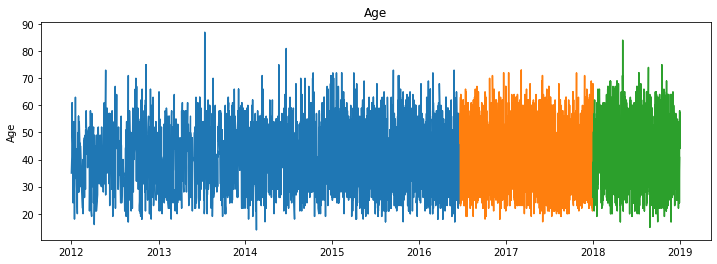

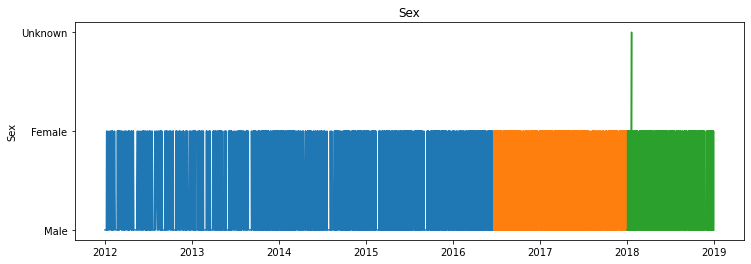

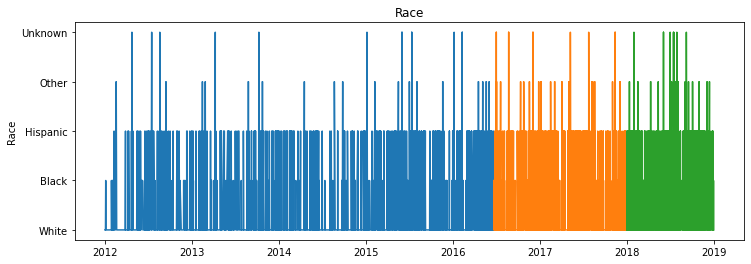

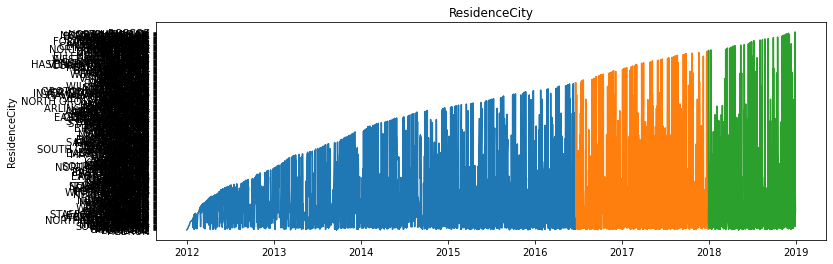

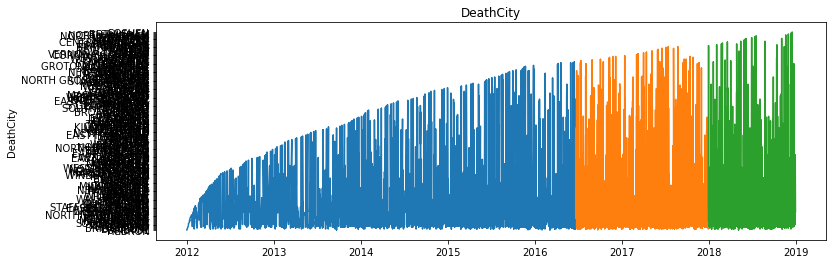

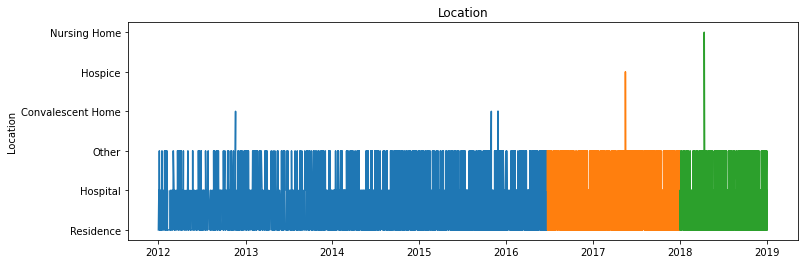

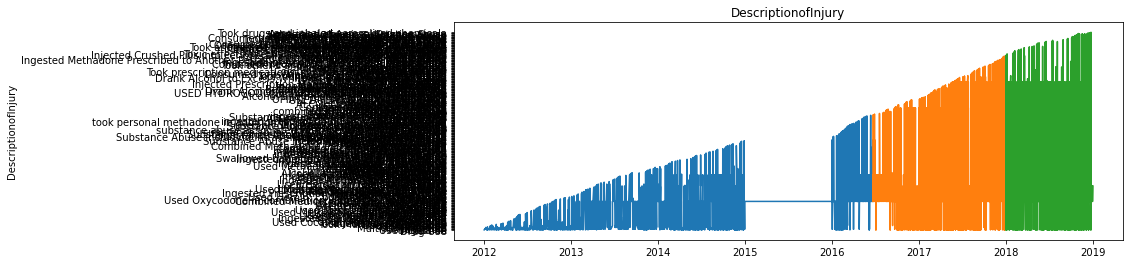

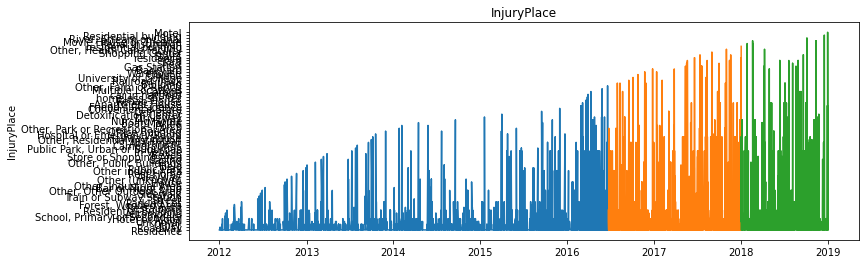

In [ ]:
#visualize distribution
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

_____________________________________________

### Question: Does the average age of deceased change over time?

In [ ]:
#what is the average age?
df.Age.mean()

In [ ]:
plt.figure(figsize=(14, 8))
df.Age.resample('W').mean().plot(label='Weekly')
df.Age.resample('M').mean().plot(label='Monthly')
df.Age.resample('Y').mean().plot(label='Monthly')

plt.plot(train['Age'])
plt.ylabel('Average Age')
plt.xlabel('Year')
plt.title('Average Age of Deceased')
plt.show()

In [ ]:
#set y to the target variable
y = train.Age.resample('D').mean()
y.head()

In [ ]:
#plot distribution of target variable
plt.figure(figsize=(14, 8))
y.plot.hist()
plt.title('Distribution of Age')
plt.xlabel('Age (in years)')
None

In [ ]:
#graph average monthly age
plt.figure(figsize=(14, 8))
ax = y.groupby(y.index.month_name()).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=90)
ax.set(title='Average Age by Month', xlabel='Month', ylabel='Average Age (in years)')
None

### Takeaways of Age Target:
- normal distribution in age
- The overall average age of the individuals in this dataset is 42 years old
- Month of the year does not help determine average age of deceased
- Younger (under age 27) individual deaths in Q1 of 2012 & 2013, Q4 of 2014 & 2015
- Ultimately, the average age does not appear to change considerably over time

___________________________________

In [ ]:
y = train.Age.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition.head()

In [ ]:
decomposition.iloc[:, 1:].plot()
None

In [ ]:
# the value returned from seasonal_decompose can itself be plotted
result.plot()
None

In [ ]:
train = train.resample('W').mean()
# create a categorical feature
train['Age_bin'] = pd.qcut(train.Age, 5, labels=['Younger', 'Young', 'Average', 'Older', 'Oldest'])
train.groupby('Age_bin').mean()

In [ ]:
(train.groupby('Age_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area()
)
plt.ylabel('% of days in monthly period')
plt.xlabel('Months')
None

____________________________

### Question: Do Heroin Deaths increase over time?

In [ ]:
df['Heroin'].sum()
#this many Heroin deaths

In [ ]:
plt.figure(figsize=(14, 8))
df.Heroin.resample('W').mean().plot(label='Weekly')
df.Heroin.resample('M').mean().plot(label='Monthly')
df.Heroin.resample('Y').mean().plot(label='Yearly')

plt.plot(train['Heroin'])
plt.ylabel('Deaths (1 = True, 0 = False)')
plt.xlabel('Year')
plt.title('Average Heroin Deaths Over Time')
plt.show()

### Takeaways of Heroin Target:
- It appears that 2529 individuals in this dataset had Heroin in their systems
    - That is approximately **49.56%** of entire dataset
- Discernible by the visualization above, Heroin deaths have actually **decreased** from 2012 to 2019
    - **but** There were several peak periods throughout that time frame

<hr style="border:2px solid black"> </hr>

# Modeling

In [ ]:
def make_predictions(Age):
    yhat_df = pd.DataFrame({'Age': [Age]}, 
                       index = validate.index)
    return yhat_df

In [ ]:
#plot and evaluate 
def plot_and_eval(yhat_df, target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(yhat_df, target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

### Last Observed Model

In [ ]:
#take the last average temp in average temp - round 2 decimal places
last_observed = round(train['Age'][-1:][0], 2)
last_observed

In [ ]:
#yhat has same index as validate
#define yhat
last_df = pd.DataFrame({'Age': [last_observed]}, 
                       index = validate.index)

last_df.head(2)

In [ ]:
yhat_df_lo = make_predictions(last_observed)
yhat_df_lo.head()

In [ ]:
target_var = 'Age'

In [ ]:
rmse_last = round(sqrt(mean_squared_error(validate[target_var], yhat_df_lo[target_var])), 3)

In [ ]:
#create a dataframe to make data easier to visualize/understand
model_df = pd.DataFrame(data=[{
    'model': 'Last Observed Value',
    'rmse': rmse_last,
    'Age': last_observed
    }])

model_df

In [ ]:
#plot last observed model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_lo[target_var])
plt.title('Actual Age Over Time vs Last Observed Model ')
plt.ylabel('Average Age')
plt.xlabel('Year')
plt.legend()
plt.show()

### Takeaways from Last Observed Model:
- The last observed age was 26 years old. Therefore, that is our projection for this model.
- The average age is 42 years old, so this model **may** be a bit low

____________________

## Simple Average Model

In [ ]:
#create the model
simple_average = round(train['Age'].mean(), 2)

In [ ]:
#use the model to predict
yhat_df_simple = make_predictions(simple_average)

In [ ]:
#calculate rmse for this model
rmse_simple = round(sqrt(mean_squared_error(validate[target_var], yhat_df_simple[target_var])), 3)

In [ ]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Simple Average',
    'rmse': rmse_simple,
    'Age': simple_average},
    ignore_index= True
    )

model_df

In [ ]:
#plot simple average model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_simple[target_var])
plt.title('Actual Age Over Time vs Simple Average Model')
plt.ylabel('Average Age')
plt.xlabel('Year')
plt.legend()
plt.show()

### Takeaways from Simple Average Model:
- This model appears to be more in line with our current values


________________________

## Rolling/Moving Average Model

In [ ]:
# compute a 3 months rolling average 
train = train.resample('M').mean()
period = 3
rolling_average = round(train['Age'].rolling(period).mean().iloc[-1], 2)

In [ ]:
yhat_df_rolling = make_predictions(rolling_average)
yhat_df_rolling.head(3)

In [ ]:
rmse_rolling = round(sqrt(mean_squared_error(validate[target_var], yhat_df_rolling[target_var])), 3)
rmse_rolling

In [ ]:
#create visual to see baseline vs LinearRegression model
model_df = model_df.append(
    {
    'model': 'Rolling Average',
    'rmse': rmse_rolling,
    'Age': rolling_average},
    ignore_index= True
    )

model_df

In [ ]:
#plot rolling average model vs actual
plt.figure(figsize = (12,4))
plt.plot(train[target_var], label = 'Train', linewidth = 1)
plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
plt.plot(yhat_df_rolling[target_var])
plt.title('Actual Age Over Time vs Rolling Average Model')
plt.ylabel('Average Age')
plt.xlabel('Year')
plt.legend()
plt.show()